In [218]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

M_Z = 91.187  # mass of Z boson (GeV)

In [219]:
dataset = pd.read_csv("./data/SM_100k.csv")
# Apply cuts
df = dataset[
    (abs(dataset["m_ll"] - M_Z) < 15)
    & (dataset["m_jj"] > 300)
    & (abs(dataset["delta_eta_jj"]) > 2.5)
]

df.count()

m_ll            69489
m_jj            69489
pt_l1           69489
pt_l2           69489
pt_j1           69489
pt_j2           69489
pt_ll           69489
eta_l1          69489
eta_l2          69489
eta_j1          69489
eta_j2          69489
delta_eta_jj    69489
delta_phi_jj    69489
dtype: int64

In [220]:
df.head()

,m_ll,m_jj,pt_l1,pt_l2,pt_j1,pt_j2,pt_ll,eta_l1,eta_l2,eta_j1,eta_j2,delta_eta_jj,delta_phi_jj
0,91.915108,817.571428,19.068266,119.288002,47.787994,174.241717,127.214313,0.601289,-0.827524,-3.112653,1.247709,-4.360361,-3.293960
1,91.554900,2404.014354,48.863130,87.367985,107.964679,177.910879,106.054348,-0.455842,0.039917,3.143773,-2.557357,5.701129,-3.725031
2,91.987715,662.842055,26.142133,128.186262,99.888379,107.257538,127.337882,2.250787,1.749627,1.845531,-1.855586,3.701117,-1.819143
3,91.241031,1242.649786,88.205101,27.274699,213.088461,244.515221,72.516153,0.011753,0.331417,1.069279,-2.251527,3.320807,2.854300
5,91.631566,1377.158854,198.064595,26.920807,180.215152,101.485660,207.975866,-0.466679,-0.903119,0.651112,-3.990533,4.641645,-1.557752


In [221]:
# select variables
selection = [
    "m_ll",
    "m_jj",
    "pt_l1",
    "pt_l2",
    "pt_j1",
    "pt_j2",
    "pt_ll",
    "eta_l1",
    "eta_l2",
    "eta_j1",
    "eta_j2",
    "delta_eta_jj",
    "delta_phi_jj",
]
df = df[selection]
for vars in ["m_ll", "m_jj", "pt_l1", "pt_l2", "pt_j1", "pt_j2", "pt_ll"]:
    df[vars] = df[vars].apply(np.log10)

In [222]:
X_train, X_test = train_test_split(df, test_size=0.2)
X_train, X_valid = train_test_split(df, test_size=0.2)

In [223]:
# MinMax scaling
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
X_valid = t.transform(X_valid)

In [224]:
# create train and test dataloaders
batch_size = 50
train_loader = DataLoader(dataset=X_train, batch_size=batch_size)
test_loader = DataLoader(dataset=X_test, batch_size=batch_size)
valid_loader = DataLoader(dataset=X_valid, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [225]:
class VAE(nn.Module):

    def __init__(self, input_dim=13, intermediate_dim=28, half_input=7, latent_dim=4):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, intermediate_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(intermediate_dim, input_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim, input_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim, input_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim, half_input),
        )

        # latent mu and variance
        self.mu_layer = nn.Linear(half_input, latent_dim)
        self.logvar_layer = nn.Linear(half_input, latent_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, half_input),
            nn.LeakyReLU(0.2),
            nn.Linear(half_input, input_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim, input_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim, input_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim, intermediate_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(intermediate_dim, input_dim),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = self.mu_layer(x), self.logvar_layer(x)
        return mu, logvar

    def reparameterization(self, mu, std):
        epsilon = torch.randn_like(std).to(device)
        z = mu + std * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        std = (0.5 * logvar).exp()
        z = self.reparameterization(mu, std)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


def loss_function(x, x_hat, mu, logvar, beta=1e-7):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    # reproduction_loss = nn.functional.mse_loss(x_hat, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss, beta * KLD

In [ ]:
def epoch():
    repro_epoch = 0
    KLD_epoch = 0
    for idx, x in enumerate(train_loader):
        x = x.float().to(device)
        optimizer.zero_grad()

        x_hat, mean, log_var = model.forward(x)
        repro, KLD = loss_function(x, x_hat, mean, log_var)
        loss = repro + KLD

        repro_epoch += repro.item()
        KLD_epoch += KLD.item()

        loss.backward()
        optimizer.step()

    return repro_epoch, KLD_epoch

In [228]:
def eval():
    model.eval()
    repro_eval = 0
    KLD_eval = 0
    for idx, x in enumerate(valid_loader):
        x = x.float().to(device)
        x = torch.clamp(x, min=0, max=1)
        x_hat, mean, log_var = model.forward(x)
        repro, KLD = loss_function(x, x_hat, mean, log_var)

        repro_eval += repro.item()
        KLD_eval += KLD.item()
    return repro_eval, KLD_eval

In [229]:
epochs = 10
for e in range(epochs):
    print(f"=== EPOCH {e} ===")
    train_repro, train_KLD = epoch()
    valid_repro, valid_KLD = eval()
    print(
        f"training loss : {train_repro/len(train_loader.dataset):.2e}, {train_KLD/len(train_loader.dataset):.2e}, eval loss : {valid_repro/len(valid_loader.dataset):.2e}, {valid_KLD/len(valid_loader.dataset):.2e}"
    )

=== EPOCH 0 ===


training loss : 4.17e-04, 6.18e+01, eval loss : 2.44e-04, 7.48e+01
=== EPOCH 1 ===
training loss : 2.19e-04, 5.89e+01, eval loss : 1.99e-04, 5.53e+01
=== EPOCH 2 ===
training loss : 1.83e-04, 6.15e+01, eval loss : 1.63e-04, 6.54e+01
=== EPOCH 3 ===
training loss : 1.60e-04, 5.71e+01, eval loss : 1.51e-04, 5.43e+01
=== EPOCH 4 ===
training loss : 1.54e-04, 5.08e+01, eval loss : 1.53e-04, 4.84e+01
=== EPOCH 5 ===
training loss : 1.51e-04, 5.12e+01, eval loss : 1.51e-04, 5.26e+01
=== EPOCH 6 ===
training loss : 1.50e-04, 5.47e+01, eval loss : 1.45e-04, 5.86e+01
=== EPOCH 7 ===
training loss : 1.49e-04, 5.74e+01, eval loss : 1.44e-04, 5.72e+01
=== EPOCH 8 ===
training loss : 1.48e-04, 5.84e+01, eval loss : 1.41e-04, 5.92e+01
=== EPOCH 9 ===
training loss : 1.46e-04, 6.11e+01, eval loss : 1.45e-04, 6.24e+01


In [230]:
model.eval()
T_test = torch.from_numpy(X_test).float().to(device)
X_hat, mean, log_var = model.forward(T_test)
X_hat = X_hat.detach().cpu()
print(T_test.size(), X_hat.size())

torch.Size([13898, 13]) torch.Size([13898, 13])


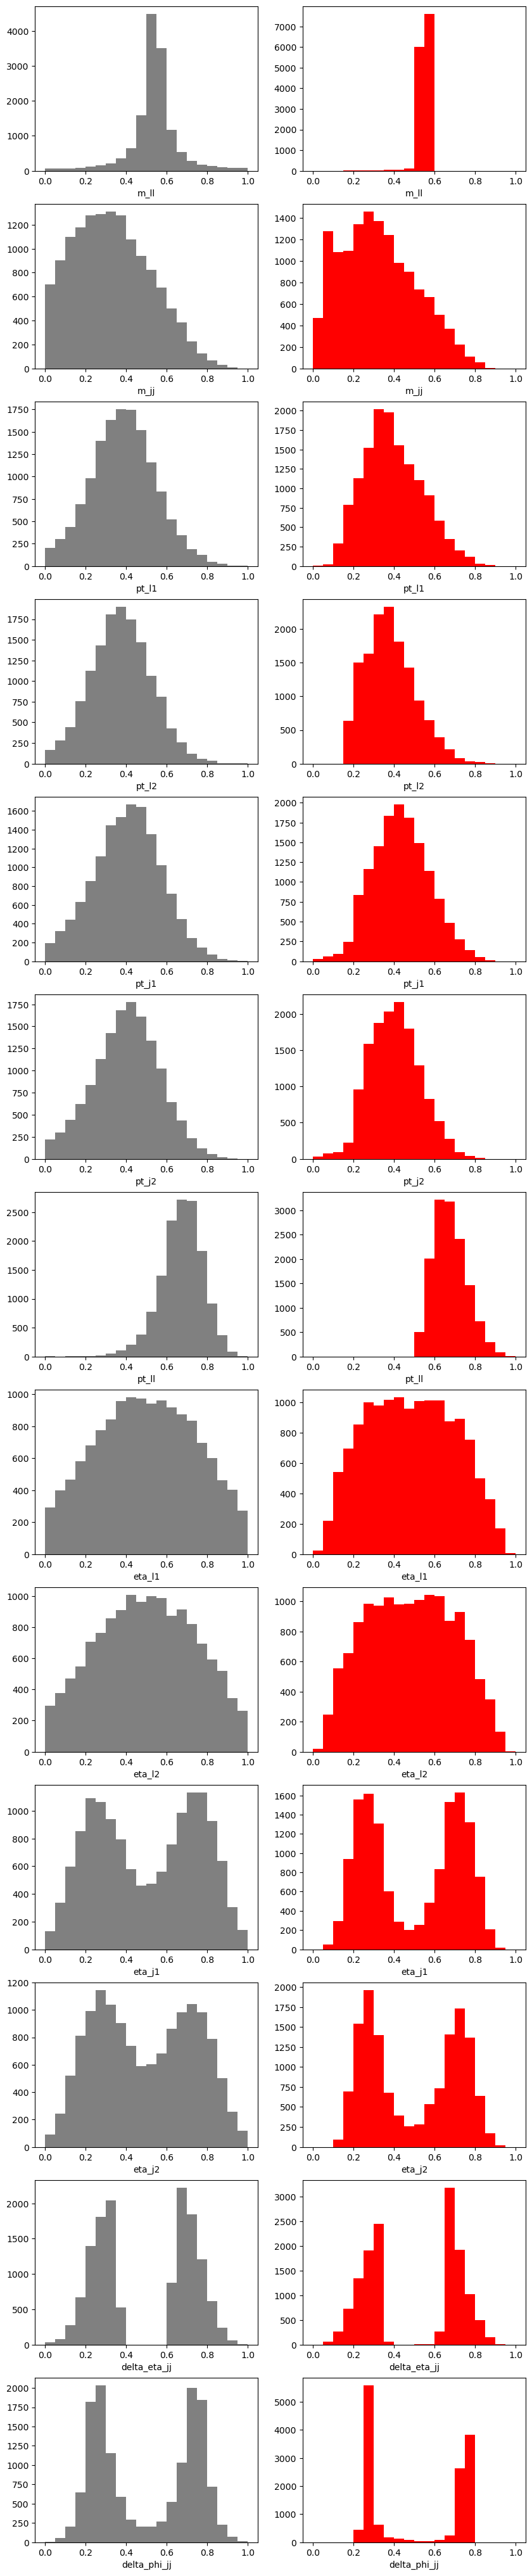

In [231]:
n_bins = 20
n_features = len(selection)
fig, ax = plt.subplots(n_features, 2, figsize=(10, 4 * n_features))
for i in range(n_features):
    ax[i, 0].hist(X_test[:, i], bins=n_bins, range=(0, 1), color="grey")
    ax[i, 1].hist(X_hat[:, i], bins=n_bins, range=(0, 1), color="red")
    ax[i, 0].set_xlabel(selection[i])
    ax[i, 1].set_xlabel(selection[i])